In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import scipy
from pandarallel import pandarallel


p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
h5 = '../cerberus_annot.h5'
h5_annot = 'cerberus_annot_triplets.h5'
ab = '../../talon/human_talon_abundance.tsv'
filt_ab = '../cerberus_filtered_abundance.tsv'
obs_col = 'sample'
min_tpm = 1
major_set = '../swan/isos_sample_gene_90.tsv'
mm_tissues = ['adrenal gland', 'heart',
              'muscle', 'brain', 'pgp1_excite_neuron',
              'pgp1_astro', 'h9_osteocyte',
              'h1', 'wtc11']

In [3]:
def compute_centroid(ca, gene=None, subset=None):
    """ 
    Compute the centroid of simplex coordinates for a given set of genes / triplets
    
    Parameters:
        gene (str): Gene ID or name
        subset (dict of str): Subset
    """
    
    df = ca.triplets.copy(deep=True)
    
    if gene:
        df, gene = cerberus.subset_df_on_gene(df, gene)

    # if we have a list of allowed sources, limit to those entries
    if subset:
        df = cerberus.subset_df(df, subset)
    
    df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
    
    df = df[['tss_ratio', 'spl_ratio', 'tes_ratio']]
    centroid = df.mean().tolist()
    
    return centroid

def simplex_dist(a, b, how='js'):
    """
    Compute the distance between two points on a simplex
    
    Parameters:
        a (np.array): Coords of pt a
        b (np.array): Coords of pt b
        how (str): How to calculate distance. {'jensenshannon'}
    
    Returns:
        dist (float): Distance b/w a and b using distance metric
    """
    if how == 'js':
        dist = scipy.spatial.distance.jensenshannon(a,b)
    return dist

def simplex_dist_x(x, suff_a=None, suff_b=None, **kwargs):
    def get_pt(x, suff):
        tss = 'tss_ratio'
        ic = 'spl_ratio'
        tes = 'tes_ratio'
        if suff:
            tss = '{}{}'.format(tss, suff)
            ic = '{}{}'.format(ic, suff)
            tes = '{}{}'.format(tes, suff)
        pt = [x[tss], x[ic], x[tes]]
        return pt
    
    a = get_pt(x, suff_a)
    b = get_pt(x, suff_b)
    dist = simplex_dist(a,b, **kwargs)
    
    return dist

## Compare centroid of all obs protein coding genes to those in each tissue

In [3]:
ca = cerberus.read(h5_annot)

In [69]:
# add biotype to subset on 
gene_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus', add_stable_gid=True)
gene_df = gene_df[['gid_stable', 'biotype_category']]
gene_df.rename({'gid_stable': 'gid'}, axis=1, inplace=True)
ca.triplets = ca.triplets.merge(gene_df, how='left', on='gid')

In [70]:
# centroid for all obs pc isoforms
pc_subset = {'source': 'obs_det',
             'biotype_category': 'protein_coding'}
pc_pt = compute_centroid(ca, subset=pc_subset)

# loop through each sample
sample_pc_subset = {'source': 'sample_det',
                    'biotype_category': 'protein_coding'}
samples = cerberus.subset_df(ca.triplets.copy(deep=True), sample_pc_subset)['sample'].unique().tolist()
dists = pd.DataFrame()
for s in samples:
    sample_pc_subset['sample'] = s
    s_pt = compute_centroid(ca, subset=sample_pc_subset)
    d = simplex_dist(pc_pt, s_pt, how='js') 
    temp = pd.DataFrame(index=[s], data=[d], columns=['dist'])
    dists = pd.concat([dists, temp], axis=0)

In [42]:
# sample = 'caco2'
# dist = .5
# dists = pd.DataFrame(index = [sample], data = [dist], columns=['dist'])
# dists

In [71]:
dists.to_csv('sample_vs_obs_dists.tsv', sep='\t')

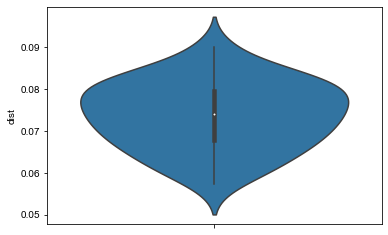

In [73]:
sns.violinplot(data=dists, y='dist')

In [3]:
dists = pd.read_csv('sample_vs_obs_dists.tsv', sep='\t')

In [6]:
dists.sort_values(by='dist', ascending=False).head()

,Unnamed: 0,dist
44,hl60,0.089918
10,pgp1_astro,0.088176
34,pgp1_endo,0.085651
0,caco2,0.083733
35,ocily7,0.083681


## Compare sample to sample major for each gene / sample combination

In [12]:
ca = cerberus.read(h5_annot)

In [25]:
# compute centroid for each sample / gene pairing for the different sources
dists = {}
for source in ['sample_det', 'sample_major']:
    df = ca.triplets.loc[ca.triplets.source == source].copy(deep=True)
    df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
    keep_cols = ['gname', 'sample', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'n_iso']
    df = df[keep_cols]
    
    # calc centroid
    df = df.groupby(['sample', 'gname']).mean().reset_index()
    df = assign_sector(df)
    dists[source] = df
    
df = dists['sample_det'].merge(dists['sample_major'],
                               on=['sample', 'gname'],
                               suffixes=('_det', '_major'))
df['same_sector'] = df.sector_det == df.sector_major

In [26]:
# compute distance
pandarallel.initialize(nb_workers=8, verbose=1)
df['dist'] = df.parallel_apply(simplex_dist_x,
                               args=('_det', '_major'),
                               axis=1)
df.sort_values(by='dist', ascending=False)[['gname', 'sample', 'dist']].head()

,gname,sample,dist
150844,COL3A1,h9_chondro,0.533181
379489,COL3A1,imr90,0.517350
117947,PSAP,h1,0.472296
256256,SNX17,hepg2,0.460264
502886,SNX17,ovary,0.460264


Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1793: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1792: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # genes detected: 599976
# genes >= 1 tpm: 292060
Applying gene type and novelty subset
Averaging over biosample
Found 50 total samples
Number of genes reported: 33772
148


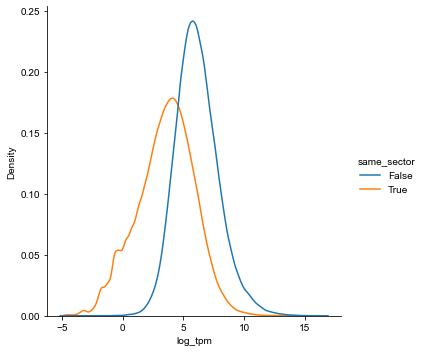

In [27]:
# gene tpm differences between the gene / sample combinations 
# that change sectors between all and major centroids
gene_df = pd.read_csv(ab, sep='\t')
gene_df, inds = get_tpm_table(gene_df,
                   groupby='sample',
                   how='gene',
                   min_tpm=1,
                   gene_subset='polya')

gene_df = gene_df.transpose()
gene_df = gene_df.melt(var_name='gid', value_name='tpm', ignore_index=False).reset_index()
gene_df.head()

gtf_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus')
gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, col='gid')
gtf_df = gtf_df[['gid_stable', 'gname']]
df = df.merge(gtf_df, how='left', on='gname')

df = df.merge(gene_df, how='left', left_on=['sample', 'gid_stable'], right_on=['biosample', 'gid'])
print(len(df.loc[df.tpm == 0].index))
df = df.loc[df.tpm != 0]
df['log_tpm'] = np.log2(df.tpm)
sns.displot(data=df, x='log_tpm', hue='same_sector', kind='kde', common_norm=False)

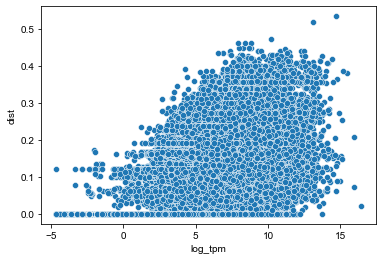

In [29]:
sns.scatterplot(data=df, x='log_tpm', y='dist')

## Compare centroid of obs vs. obs major for each gene


In [4]:
ca = cerberus.read(h5_annot)

In [5]:
# compute centroid for each sample / gene pairing for the different sources
dists = {}
for source in ['sample_det', 'sample_major']:
    df = ca.triplets.loc[ca.triplets.source == source].copy(deep=True)
    df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
    keep_cols = ['gname', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'n_iso']
    df = df[keep_cols]
    df = df.groupby(['gname']).mean().reset_index()
    df = assign_sector(df)
    dists[source] = df
    
df = dists['sample_det'].merge(dists['sample_major'],
                               on=['gname'],
                               suffixes=('_det', '_major'))
df['same_sector'] = df.sector_det == df.sector_major

In [13]:
pandarallel.initialize(nb_workers=8, verbose=1)
df['dist'] = df.parallel_apply(simplex_dist_x,
                               args=('_det', '_major'),
                               axis=1)

In [14]:
# filter
print(len(df.index))

# det and major sectors are different
df = df.loc[df.same_sector==False]
print(len(df.index))


# major sector isn't simple
df = df.loc[df.sector_major != 'simple']
print(len(df.index))


26770
1956
1445


In [16]:
df.sort_values(by='dist', ascending=False)

,gname,tss_ratio_det,tes_ratio_det,spl_ratio_det,n_iso_det,sector_det,tss_ratio_major,tes_ratio_major,spl_ratio_major,n_iso_major,sector_major,same_sector,dist
22679,SNX17,0.086354,0.173903,0.739743,16.260000,splicing,0.275704,0.493075,0.231221,2.000000,mixed,False,0.368569
20824,RPL41,0.091598,0.086703,0.821699,10.640000,splicing,0.319000,0.319000,0.362000,1.200000,mixed,False,0.338410
18244,PDIA6,0.105935,0.289801,0.604263,18.960000,splicing,0.272727,0.545455,0.181818,2.000000,tes,False,0.314254
19484,PSMC3,0.248943,0.135914,0.615144,10.020000,splicing,0.531935,0.272634,0.195431,2.020000,tss,False,0.308154
20545,RPL10A,0.068020,0.069415,0.862565,13.400000,splicing,0.268857,0.268857,0.462286,1.880000,mixed,False,0.306801
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25192,UGGT1,0.225525,0.500139,0.274336,5.627907,tes,0.228018,0.493757,0.278225,4.883721,mixed,False,0.004529
24587,TRAF6,0.271927,0.505453,0.222620,2.200000,tes,0.275811,0.499458,0.224732,2.120000,mixed,False,0.004280
17970,PARP11,0.222754,0.278495,0.498751,3.562500,mixed,0.224612,0.273877,0.501511,3.270833,splicing,False,0.003672
12991,IKBKB,0.261621,0.498882,0.239497,4.833333,mixed,0.257334,0.501877,0.240789,3.916667,tes,False,0.003458


In [22]:
df.loc[df.gname == 'ELN']

,gname,tss_ratio_det,tes_ratio_det,spl_ratio_det,n_iso_det,sector_det,tss_ratio_major,tes_ratio_major,spl_ratio_major,n_iso_major,sector_major,same_sector,dist
5396,ELN,0.209073,0.277852,0.513075,28.8,splicing,0.216262,0.288235,0.495502,13.9,mixed,False,0.012431


In [24]:
df.loc[df.gname == 'SNX17']

,gname,tss_ratio_det,tes_ratio_det,spl_ratio_det,n_iso_det,sector_det,tss_ratio_major,tes_ratio_major,spl_ratio_major,n_iso_major,sector_major,same_sector,dist
22679,SNX17,0.086354,0.173903,0.739743,16.26,splicing,0.275704,0.493075,0.231221,2.0,mixed,False,0.368569


In [17]:
# plot major and all isoforms for a given gene
def plot_all_major_isos(ca, gene):
    
    c_dict, order = get_biosample_colors()
    c_dict[np.nan] = 'k'
    mmap = {'v40': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2'}
    
    # all 
    subset = {'source': ['v40', 'obs_det', 'sample_det']}
    df = ca.plot_simplex(top='splicing_ratio', 
                gene=gene,
                hue='sample',
                cmap=c_dict,
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset={'source': ['v40', 'obs_det', 'sample_det']},
                size_scale=0.5,
                fname='figures/simplex_{}.pdf'.format(gene.lower()))

    # major
    subset = {'source': ['v40', 'obs_det', 'sample_det']}
    df = ca.plot_simplex(top='splicing_ratio', 
                gene=gene,
                hue='sample',
                cmap=c_dict,
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset={'source': ['v40', 'obs_det', 'sample_major']},
                size_scale=0.5,
                fname='figures/simplex_{}_major.pdf'.format(gene.lower()))

2.5
75.0
(5.358, 5.0)
2.5
75.0
(5.358, 5.0)


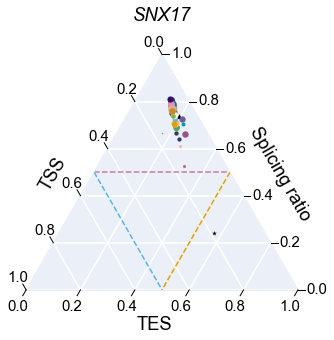

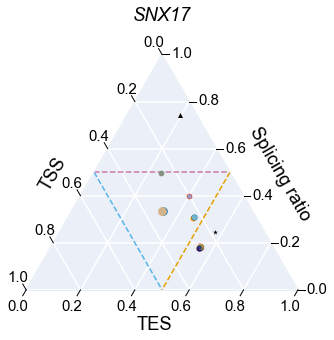

In [19]:
plot_all_major_isos(ca, 'SNX17')

2.5
75.0
(5.358, 5.0)
2.5
75.0
(5.358, 5.0)


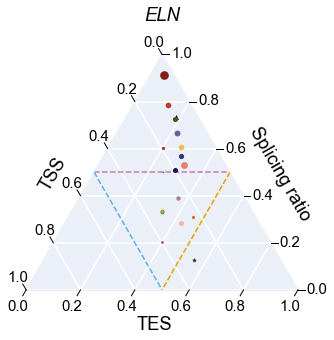

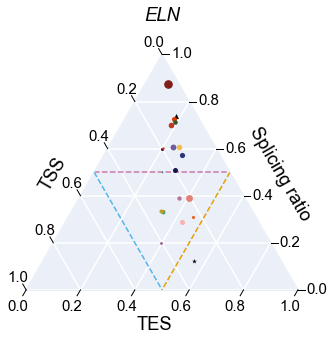

In [8]:
plot_all_major_isos(ca, 'ELN')

2.5
75.0
(5.358, 5.0)
2.5
75.0
(5.358, 5.0)


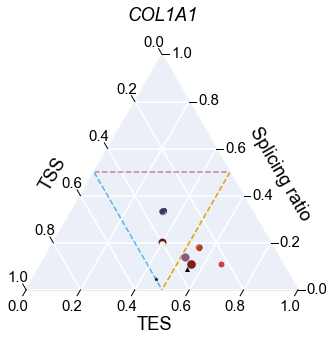

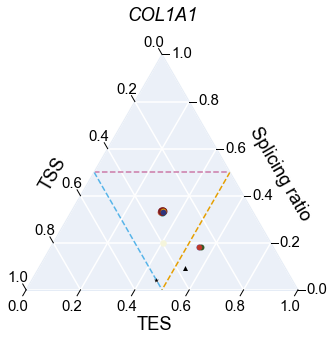

In [7]:
plot_all_major_isos(ca, 'COL1A1')

2.5
75.0
(5.358, 5.0)
2.5
75.0
(5.358, 5.0)


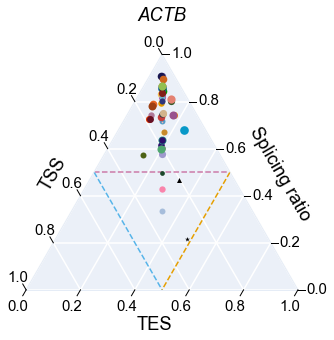

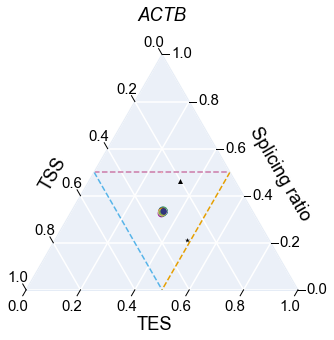

In [64]:
plot_all_major_isos(ca, 'ACTB')

2.5
75.0
(5.358, 5.0)
2.5
75.0
(5.358, 5.0)


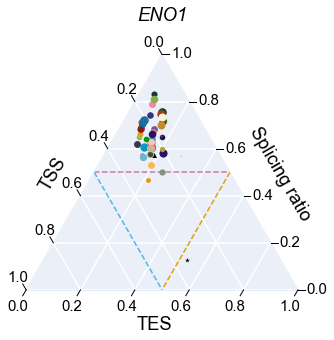

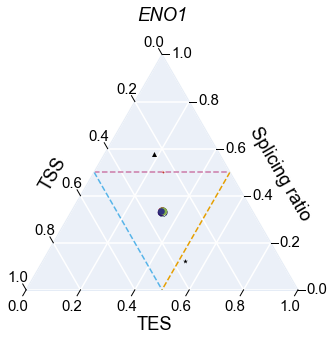

In [65]:
plot_all_major_isos(ca, 'ENO1')

2.5
75.0
(5.358, 5.0)
2.5
75.0
(5.358, 5.0)


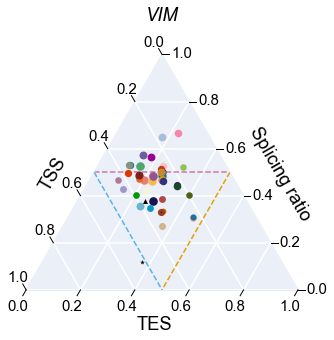

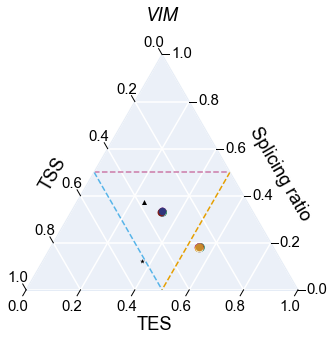

In [66]:
plot_all_major_isos(ca, 'VIM')

## scratch

In [26]:
# c = compute_centroid(ca, subset = {'source': 'obs_det', 'biotype_category': 'protein_coding'})
# a = compute_centroid(ca,
#                      gene='MEF2C',
#                      subset={'source': 'obs_det'})
# a = compute_centroid(ca,
#                      gene='ELN',
#                      subset={'source': 'obs_det'})
# b = compute_centroid(ca,
#                      gene='COL3A1',
#                      subset={'source': 'obs_det'})
# print(a)
# print(b)

[0.07894736842105263, 0.7368421052631579, 0.18421052631578946]
[0.0425531914893617, 0.8297872340425532, 0.1276595744680851]


In [28]:
simplex_dist(a,b, how='js')

0.0820051749277829